<a name='0'></a>
## Import Functions and  Read Data

In [210]:
# run this cell to import nltk
import nltk
import pandas as pd 
import re
import string
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer



df=pd.read_csv('sentiment_analysis.csv')
df

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...
...,...,...,...
7915,7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7916,7917,0,We would like to wish you an amazing day! Make...
7917,7918,0,Helping my lovely 90 year old neighbor with he...
7918,7919,0,Finally got my #smart #pocket #wifi stay conne...


In [211]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [212]:


    

def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks    
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean


def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs


## Useful plots for EDA

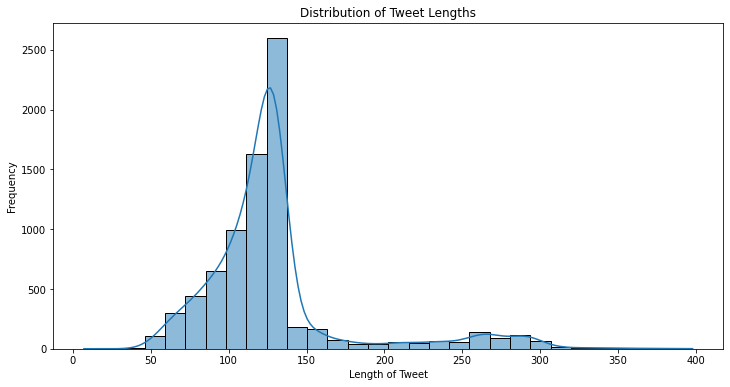

In [213]:


# Plot the distribution of tweet lengths
tweet_lengths = df['tweet'].str.len()
plt.figure(figsize=(12, 6))
sns.histplot(tweet_lengths, bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()







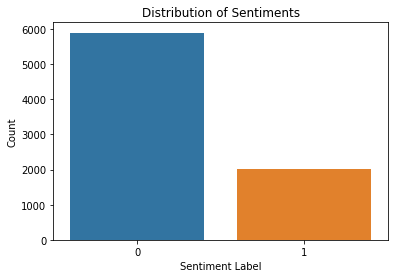

In [214]:
# Plot the distribution of labels (sentiments)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

### Downsampling the data for balanced classes 

In [215]:

def balance_dataframe(df, label_column):
    """
    Balance the DataFrame by undersampling the majority class.

    Parameters:
    df (pd.DataFrame): The DataFrame to balance.
    label_column (str): The name of the column containing the class labels.

    Returns:
    pd.DataFrame: A balanced DataFrame.
    """
    # Calculate the counts of each class
    class_counts = df[label_column].value_counts()
    
    # Find the count of the minority class
    min_class_count = class_counts.min()

    # Create a list to store the DataFrame slices
    df_slices = []

    for class_label in class_counts.index:
        df_class = df[df[label_column] == class_label]
        df_class_sampled = df_class.sample(min_class_count, random_state=42)
        df_slices.append(df_class_sampled)

    # Concatenate the downsampled DataFrames
    balanced_df = pd.concat(df_slices)

    # Shuffle the DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df
df=balance_dataframe(df,'label')

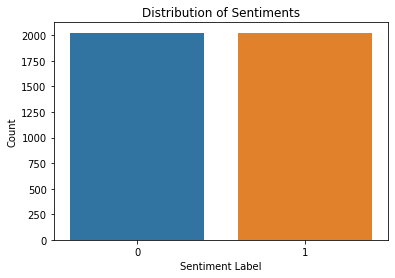

In [216]:
# Plot the distribution of the balanced  labels (sentiments)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

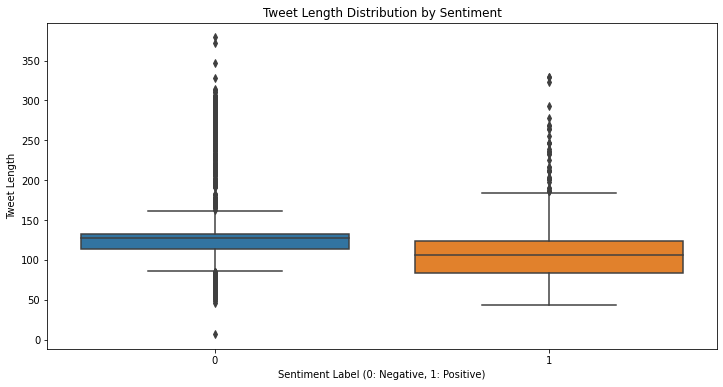

In [217]:
#Sentiment distribution by tweet length
df2=pd.DataFrame()
df2['tweet_length'] = df['tweet'].str.len()
df2['label']=df['label']
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='tweet_length', data=df2)
plt.title('Tweet Length Distribution by Sentiment')
plt.xlabel('Sentiment Label (0: Negative, 1: Positive)')
plt.ylabel('Tweet Length')
plt.show()

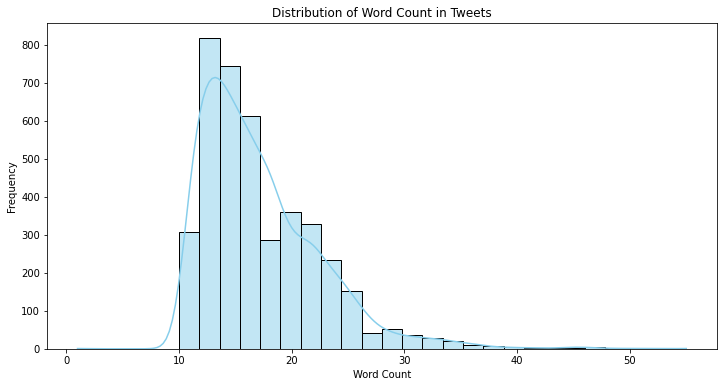

In [218]:

# Plot the distribution of the number of words in each tweet
df2['word_count'] = df['tweet'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(df2['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Word Count in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()



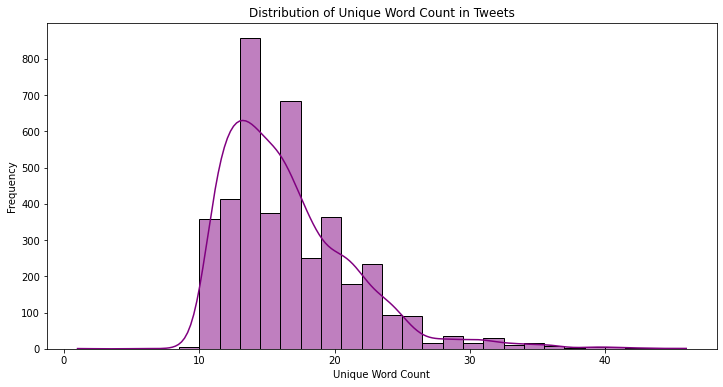

In [219]:

# Plot the number of unique words in each tweet
df2['unique_word_count'] = df['tweet'].apply(lambda x: len(set(x.split())))
plt.figure(figsize=(12, 6))
sns.histplot(df2['unique_word_count'], bins=30, kde=True, color='purple')
plt.title('Distribution of Unique Word Count in Tweets')
plt.xlabel('Unique Word Count')
plt.ylabel('Frequency')
plt.show()

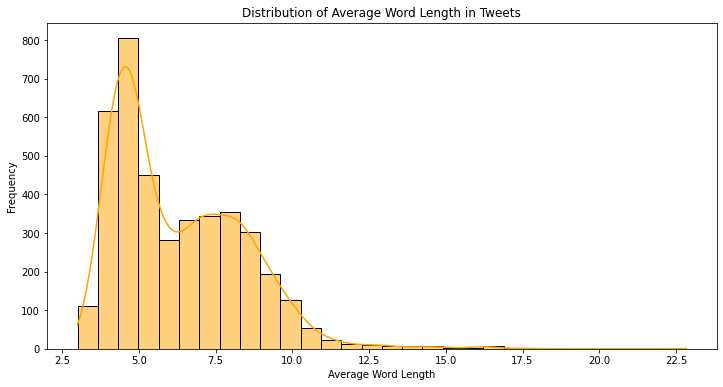

In [220]:

# Plot the average word length in each tweet
df2['avg_word_length'] = df['tweet'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
plt.figure(figsize=(12, 6))
sns.histplot(df2['avg_word_length'], bins=30, kde=True, color='orange')
plt.title('Distribution of Average Word Length in Tweets')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.show()

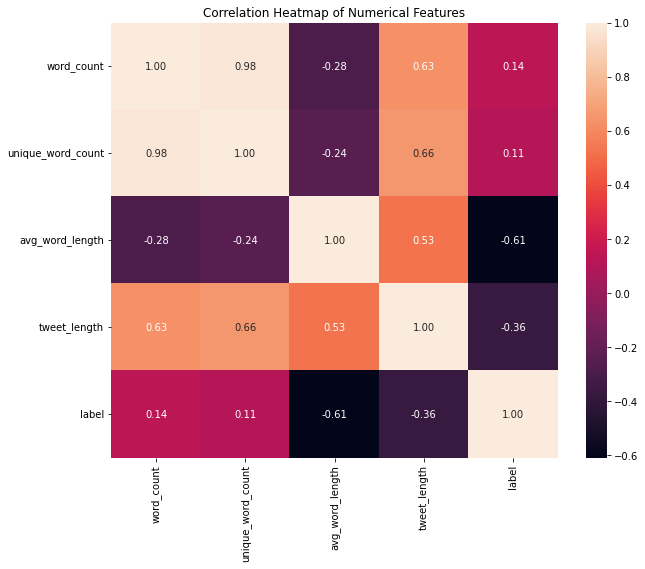

In [221]:


# Correlation heatmap between numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df2[['word_count', 'unique_word_count', 'avg_word_length', 'tweet_length', 'label']].corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## ## Split the Data into Training & Testing sets 

In [222]:

def data_split(data, target_column, test_size=0.2, random_state=42):
    # Assuming target is already binary (0s and 1s) and categorical
    target = data[target_column]

    # Drop the original target column and 'id' column from the features
    features = data.drop(columns=[target_column, 'id'])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)

    # Convert target variables to NumPy arrays and reshape them
    y_train = y_train.to_numpy().reshape(-1, 1)
    y_test = y_test.to_numpy().reshape(-1, 1)

    # Convert feature variables to NumPy arrays
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    return X_train, X_test, y_train, y_test

    

train_x, test_x, train_y, test_y = data_split(df,'label')

In [223]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))
print("train_x.shape = " + str(train_x.shape))
print("test_x.shape = " + str(test_x.shape))

train_y.shape = (3241, 1)
test_y.shape = (811, 1)
train_x.shape = (3241, 1)
test_x.shape = (811, 1)


In [224]:
# convert the data into list of tweets and list of labels 
train_x=np.squeeze(train_x)
test_x=np.squeeze(test_x)


In [225]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 9186


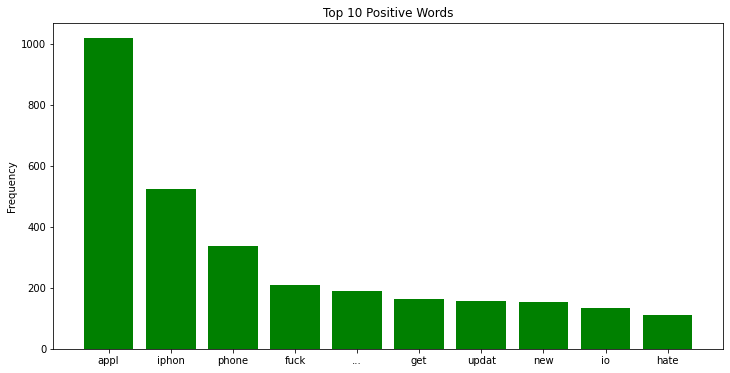

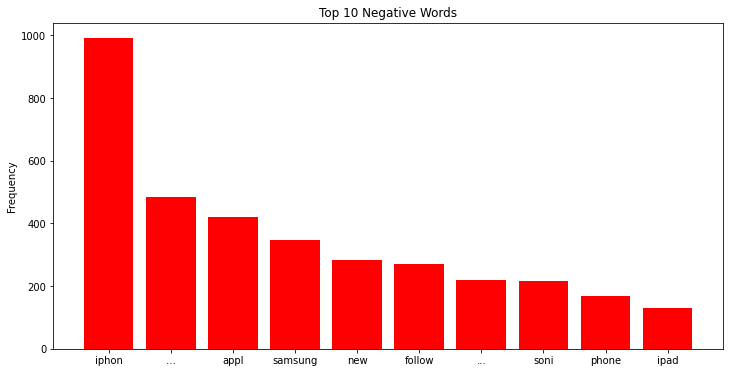

In [226]:

# Function to sort the frequencies for positive and negative sentiments
def sort_freqs(freqs):
    pos_freqs = {}
    neg_freqs = {}
    
    for key, value in freqs.items():
        word, sentiment = key
        if sentiment == 1:
            pos_freqs[word] = pos_freqs.get(word, 0) + value
        else:
            neg_freqs[word] = neg_freqs.get(word, 0) + value

    # Sort the frequencies
    sorted_pos = sorted(pos_freqs.items(), key=lambda x: x[1], reverse=True)
    sorted_neg = sorted(neg_freqs.items(), key=lambda x: x[1], reverse=True)

    return sorted_pos[:10], sorted_neg[:10]

# Getting the top 10 positive and negative words
top_pos, top_neg = sort_freqs(freqs)

# Separating words and counts for plotting
pos_words, pos_counts = zip(*top_pos)
neg_words, neg_counts = zip(*top_neg)

# Plotting the top positive words
plt.figure(figsize=(12, 6))
plt.bar(pos_words, pos_counts, color='green')
plt.title('Top 10 Positive Words')
plt.ylabel('Frequency')
plt.show()

# Plotting the top negative words
plt.figure(figsize=(12, 6))
plt.bar(neg_words, neg_counts, color='red')
plt.title('Top 10 Negative Words')
plt.ylabel('Frequency')
plt.show()

### Process Tweet
The given function 'process_tweet' tokenizes the tweet into individual words, removes stop words and applies stemming.

In [227]:

print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 trying to speak to someone at #apple to sort a new battery for my mac book apple #big #time #poorservice

This is an example of the processed version of the tweet: 
 ['tri', 'speak', 'someon', 'appl', 'sort', 'new', 'batteri', 'mac', 'book', 'appl', 'big', 'time', 'poorservic']



##  Logistic Regression 




In [228]:
# sigmoid Function
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    
    
    # calculate the sigmoid of z
    h = 1/(1+np.exp(-z))
    
    
    return h

#### Logistic Regression: Regression and a Sigmoid

Logistic regression takes a regular linear regression, and applies a sigmoid to the output of the linear regression.

Regression:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
Note that the $\theta$ values are "weights". If you took the deep learning specialization, we referred to the weights with the 'w' vector.  In this course, we're using a different variable $\theta$ to refer to the weights.

Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
We will refer to 'z' as the 'logits'.

<a name='1-2'></a>
### 1.2 - Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of training example 'i'.
* $h(z^{(i)})$ is the model's prediction for the training example 'i'.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* Note that when the model predicts 1 ($h(z(\theta)) = 1$) and the label 'y' is also 1, the loss for that training example is 0. 
* Similarly, when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0. 
* However, when the model prediction is close to 1 ($h(z(\theta)) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.

In [229]:
# verify that when the model predicts close to 1, but the actual label is 0, the loss is a large positive value
-1 * (1 - 0) * np.log(1 - 0.9999) # loss is about 9.2

9.210340371976294

* Likewise, if the model predicts close to 0 ($h(z) = 0.0001$) but the actual label is 1, the first term in the loss function becomes a large number: $-1 \times log(0.0001) \approx 9.2$.  The closer the prediction is to zero, the larger the loss.

In [230]:
# verify that when the model predicts close to 0 but the actual label is 1, the loss is a large positive value
-1 * np.log(0.0001) # loss is about 9.2

9.210340371976182

#### Update the weights

To update your weight vector $\theta$, you will apply gradient descent to iteratively improve your model's predictions.  
The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j \tag{5}$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x^{(i)}_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.


In [231]:

def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''

   
    # get 'm', the number of rows in matrix x
    m = x.shape[0]
    
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x, theta)
        
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = (-1/m)*(  np.dot( y.transpose(), np.log(h) )  +   np.dot( (1-y).transpose(), np.log(1-h))   )
        

        # update the weights theta
        theta = theta - (alpha/m)*(np.dot(x.transpose(),h-y))
        
   
    J = float(J)
    return J, theta

In [232]:

# Construct a synthetic test case using numpy PRNG functions
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]



##  Extracting the Features



In [233]:

def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    Input: 
        tweet: a string containing one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    
    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(3) 
    
    # bias term is set to 1
    x[0] = 1 
    

    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[1] += freqs.get((word,1.0),0.0)
        
        # increment the word count for the negative label 0
        x[2] += freqs.get((word,0.0),0.0)
        

    
    x = x[None, :]  # adding batch dimension for further processing
    assert(x.shape == (1, 3))
    return x


##  Training the Model





In [234]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 4000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.61626670.
The resulting vector of weights is [5e-08, 0.00037401, -0.00040591]



##  Test  Logistic Regression



In [235]:
# UNQ_C4 GRADED FUNCTION: predict_tweet
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''

    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x,theta))
    
    
    return y_pred


###  Check the Performance using the Test Set



In [236]:


def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet):
    """
    Test the logistic regression model and return its accuracy and classification report.

    Parameters:
    test_x (list): A list of tweets.
    test_y (np.ndarray): A numpy array with the corresponding labels for the list of tweets.
    freqs (dict): A dictionary with the frequency of each pair (or tuple).
    theta (np.ndarray): Weight vector of dimension (3, 1).
    predict_tweet (function): A function to predict the sentiment of a tweet.

    Returns:
    float, dict: The accuracy and a dictionary containing the classification report.
    """
    
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # Calculate the accuracy
    accuracy = np.mean(np.array(y_hat) == np.squeeze(test_y))

    # Generate classification report
    report = classification_report(np.squeeze(test_y), y_hat, output_dict=True)

    return accuracy, report


def print_classification_report(report):
    """
    Print the classification report.

    Parameters:
    report (dict): A dictionary containing the classification report.
    """
    print("Classification Report:")
    for key, value in report.items():
        if isinstance(value, dict):
            print(f"\nClass {key}:")
            for score, score_value in value.items():
                print(f"{score.capitalize()}: {score_value:.2f}")
        else:
            print(f"{key.capitalize()}: {value:.2f}")




In [240]:
accuracy, report = test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet)
print("Accuracy:", round(accuracy,2)*100,"%")
print_classification_report(report)

Accuracy: 77.0 %
Classification Report:

Class 0:
Precision: 0.75
Recall: 0.82
F1-score: 0.78
Support: 412.00

Class 1:
Precision: 0.79
Recall: 0.72
F1-score: 0.75
Support: 399.00
Accuracy: 0.77

Class macro avg:
Precision: 0.77
Recall: 0.77
F1-score: 0.77
Support: 811.00

Class weighted avg:
Precision: 0.77
Recall: 0.77
F1-score: 0.77
Support: 811.00



##  Error Analysis



In [238]:
# Some error analysis 
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: Monday and fresh juice! #carrot #ginger #celery #apple #yum #healthy #backontrack … https://www.instagram.com/p/BFLpRoyOIn-/
THE PROCESSED TWEET IS: ['monday', 'fresh', 'juic', 'carrot', 'ginger', 'celeri', 'appl', 'yum', 'healthi', 'backontrack', '…']
0	0.50417307	b'monday fresh juic carrot ginger celeri appl yum healthi backontrack '
THE TWEET IS: Grandma's apple pie #grandma #applepie #enjoy #good #food #apple #instafood #instagood… http://instagram.com/p/qcK9saJwbh/
THE PROCESSED TWEET IS: ["grandma'", 'appl', 'pie', 'grandma', 'applepi', 'enjoy', 'good', 'food', 'appl', 'instafood', 'instagood', '…']
0	0.54811613	b"grandma' appl pie grandma applepi enjoy good food appl instafood instagood "
THE TWEET IS: Piece of heaven Paula Red cheered me up #apple #paulared #yummy #goodstartoftheday https://www.instagram.com/p/BJesLKbBeRT/
THE PROCESSED TWEET IS: ['piec', 'heaven', 'paula', 'red', 'cheer', 'appl', 'paular', 'yummi', 'goodstartoftheday']
0	0.5


## Predict with your own Tweet

In [239]:
# Feel free to change the tweet below
my_tweet = '    write your tweet here  '
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['write', 'tweet']
[[0.50048925]]
Positive sentiment
